# [EX12] Movielens 영화 SBR

### 목차
1. 데이터의 전처리      
    1) Data Load       
    2) Session Length       
    3) session time       
    4) Rating score      
    5) Data Cleansing    
2. 미니 배치의 구성
3. 모델 구성
4. 모델 학습
5. 모델 테스트(1)
6. 모델 테스트(2)
7. 모델 테스트(3)
8. 결과

## 1. 데이터의 전처리

### 1) Data Load

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
# 유저id 수, 영화 수
data['UserId'].nunique(), data['ItemId'].nunique(), data['Rating'].nunique()

(6040, 3706, 5)

### 2) Session Length

In [4]:
# 각 유저별 영화를 보고 리뷰를 남긴 개수
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
# 한 유저당 리뷰 수 중간 값, 리뷰 평균 값 
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [6]:
# 가장 적은 리뷰 수, 가장 많은 리뷰 수
user_length.min(), user_length.max()

(20, 2314)

In [7]:
# 99.9% 유저들의 이하 리뷰 수를 가짐
user_length.quantile(0.999)  

1343.181000000005

In [8]:
long_rating = user_length[user_length == 2314].index[0]
data[data['UserId']==long_rating]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [9]:
# 길이 기준 하위 99.9%까지의 분포 누적합
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

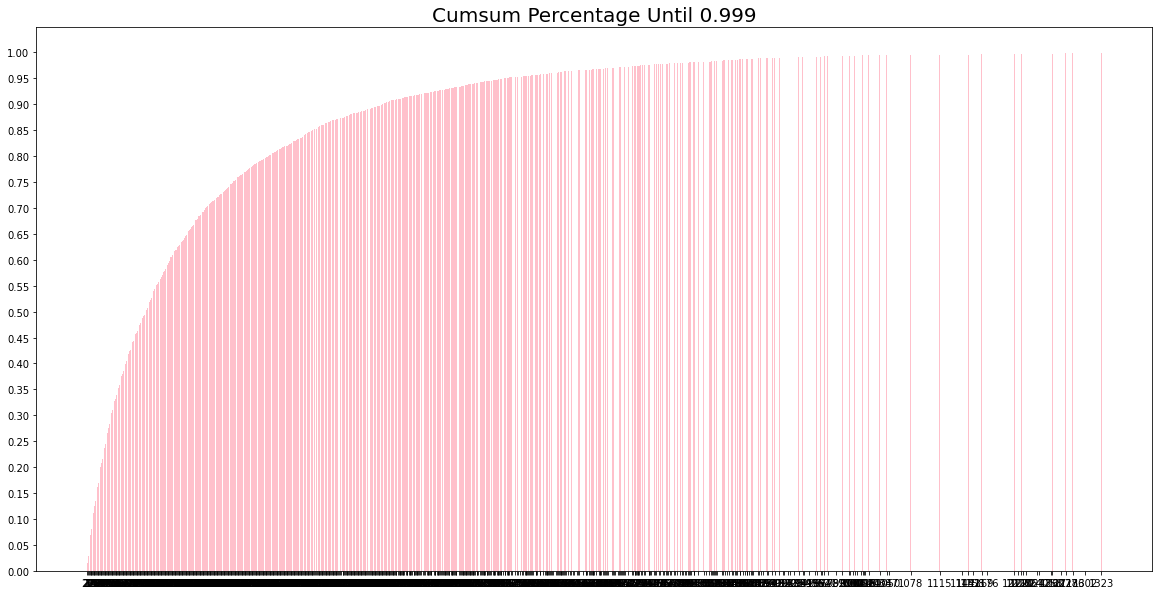

In [10]:
# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='pink')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 3) session time

In [11]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [13]:
data['Year'] = data['Time'].dt.strftime('%Y')

In [14]:
data

,UserId,ItemId,Rating,Time,Year
31,1,3186,4,2000-12-31 22:00:19,2000
22,1,1270,5,2000-12-31 22:00:55,2000
27,1,1721,4,2000-12-31 22:00:55,2000
37,1,1022,5,2000-12-31 22:00:55,2000
24,1,2340,3,2000-12-31 22:01:43,2000
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,2001
999988,6040,1921,4,2001-08-10 14:41:04,2001
1000172,6040,1784,3,2001-08-10 14:41:04,2001
1000167,6040,161,3,2001-08-10 14:41:26,2001


### 4) Rating score

In [15]:
y00_count = data[data['Year'].str.contains('2000')]
y01_count = data[data['Year'].str.contains('2001')]
y02_count = data[data['Year'].str.contains('2002')]
y03_count = data[data['Year'].str.contains('2003')]

In [16]:
# 2000년 Rating 높은 영화 
rating_score = y00_count.groupby('Rating')['ItemId'].count()
rating_score

Rating
1     51027
2     96069
3    234296
4    314446
5    208919
Name: ItemId, dtype: int64

In [17]:
# 2001년 Rating 높은 영화 
rating_score = y01_count.groupby('Rating')['ItemId'].count()
rating_score

Rating
1     3539
2     7986
3    19150
4    24839
5    12544
Name: ItemId, dtype: int64

In [18]:
# 2002년 Rating 높은 영화 
rating_score = y02_count.groupby('Rating')['ItemId'].count()
rating_score

Rating
1    1356
2    3113
3    6898
4    8500
5    4179
Name: ItemId, dtype: int64

In [19]:
# 2003년 Rating 높은 영화 
rating_score = y03_count.groupby('Rating')['ItemId'].count()
rating_score

Rating
1     252
2     389
3     853
4    1186
5     668
Name: ItemId, dtype: int64

In [20]:
orginal_data_size = len(data)
orginal_data_size

1000209

In [21]:
# Rating 3점 이상만 남깁니다.
data = data[data['Rating']>=3]
filtered_data_size = len(data)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [22]:
data[data['Rating']==2]

,UserId,ItemId,Rating,Time,Year


In [23]:
data[data['Rating']==1]

,UserId,ItemId,Rating,Time,Year


### 5) Data Cleansing

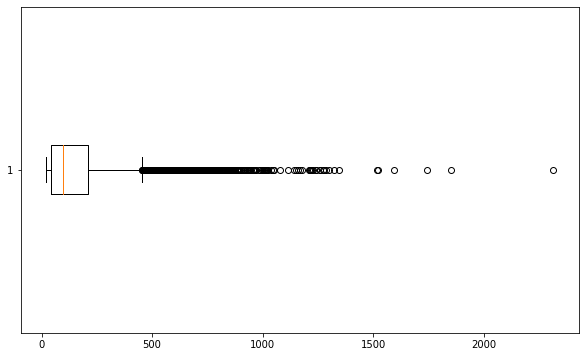

In [24]:
# 이상치 확인
plt.figure(figsize=(10,6))
plt.boxplot(user_length, vert=0)
plt.show()

In [25]:
# 너무 많은 리뷰를 가진 유저는 제거
def cleanse_recursive(data: pd.DataFrame, longest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_long_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_long_session(data: pd.DataFrame, longest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len < longest].index
    data = data[data['UserId'].isin(session_use)]
    return data

In [26]:
data = cleanse_recursive(data, 2314)

In [27]:
user_length = data.groupby('UserId').size()

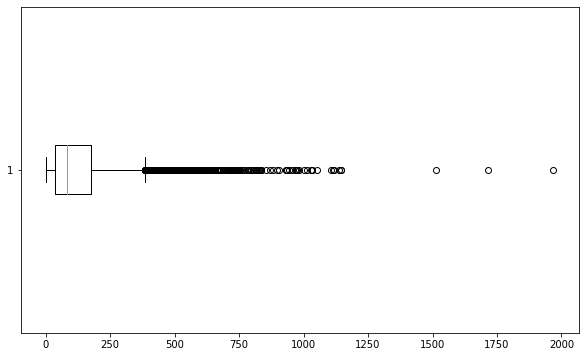

In [28]:
# 이상치 제거
plt.figure(figsize=(10,6))
plt.boxplot(user_length, vert=0)
plt.show()

In [29]:
data

,UserId,ItemId,Rating,Time,Year
31,1,3186,4,2000-12-31 22:00:19,2000
22,1,1270,5,2000-12-31 22:00:55,2000
27,1,1721,4,2000-12-31 22:00:55,2000
37,1,1022,5,2000-12-31 22:00:55,2000
24,1,2340,3,2000-12-31 22:01:43,2000
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,2001
999988,6040,1921,4,2001-08-10 14:41:04,2001
1000172,6040,1784,3,2001-08-10 14:41:04,2001
1000167,6040,161,3,2001-08-10 14:41:26,2001


### 6) Train / Valid / Test split

<AxesSubplot:>

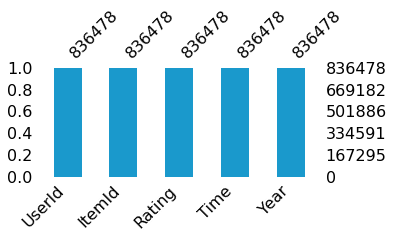

In [30]:
# 결측치 확인
import missingno as msno
msno.bar(data.iloc[:, :], color=(0.1, 0.6, 0.8), figsize=(5,2))

In [31]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [32]:
train, test = split_by_date(data, n_days= 420)
train, val = split_by_date(train, n_days= 240)

In [33]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [34]:
stats_info(train, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 595234
	 Sessions: 5168
	 Items: 3556
	 First Time : 2000-04-25 23:25:58
	 Last Time : 2001-05-08 14:36:33

* valid Set Stats Info
	 Events: 61953
	 Sessions: 297
	 Items: 3072
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-01-03 23:33:46

* test Set Stats Info
	 Events: 179190
	 Sessions: 574
	 Items: 3381
	 First Time : 2000-04-27 01:55:48
	 Last Time : 2003-02-28 17:49:50



In [37]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [38]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'val.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. 미니 배치의 구성

In [39]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""
    
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()     # 각 세션이 시작된 인덱스를 가진 변수
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId
    
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [40]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Year,item_idx
31,1,3186,4,2000-12-31 22:00:19,2000,0
22,1,1270,5,2000-12-31 22:00:55,2000,1
27,1,1721,4,2000-12-31 22:00:55,2000,2
37,1,1022,5,2000-12-31 22:00:55,2000,3
24,1,2340,3,2000-12-31 22:01:43,2000,4
36,1,1836,5,2000-12-31 22:02:52,2000,5
3,1,3408,4,2000-12-31 22:04:35,2000,6
7,1,2804,5,2000-12-31 22:11:59,2000,7
47,1,1207,4,2000-12-31 22:11:59,2000,8
0,1,1193,5,2000-12-31 22:12:40,2000,9


In [41]:
train_dataset.click_offsets

array([     0,     53,    169, ..., 595097, 595115, 595234], dtype=int32)

In [42]:
train_dataset.session_idx

array([   0,    1,    2, ..., 5165, 5166, 5167])

In [43]:
# Session DataLoader
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [44]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Year,item_idx
31,1,3186,4,2000-12-31 22:00:19,2000,0
22,1,1270,5,2000-12-31 22:00:55,2000,1
27,1,1721,4,2000-12-31 22:00:55,2000,2
37,1,1022,5,2000-12-31 22:00:55,2000,3
24,1,2340,3,2000-12-31 22:01:43,2000,4
36,1,1836,5,2000-12-31 22:02:52,2000,5
3,1,3408,4,2000-12-31 22:04:35,2000,6
7,1,2804,5,2000-12-31 22:11:59,2000,7
47,1,1207,4,2000-12-31 22:11:59,2000,8
0,1,1193,5,2000-12-31 22:12:40,2000,9


In [45]:
iter_ex = iter(train_data_loader)

In [46]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 3. 모델 구성

In [48]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [50]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [56]:
class Args:
    def __init__(self, train, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.val = val
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_sessions = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)

In [57]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    541200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습

In [58]:
def train_model(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [59]:
train_model(model, args)

Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.55]

	 - Recall@20 epoch 1: 0.163450
	 - MRR@20    epoch 1: 0.039653



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.97]  

	 - Recall@20 epoch 2: 0.274280
	 - MRR@20    epoch 2: 0.071157



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.69] 

	 - Recall@20 epoch 3: 0.317479
	 - MRR@20    epoch 3: 0.088611



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.53] 

	 - Recall@20 epoch 4: 0.342371
	 - MRR@20    epoch 4: 0.099512



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.44] 

	 - Recall@20 epoch 5: 0.354167
	 - MRR@20    epoch 5: 0.107407



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.41]  

	 - Recall@20 epoch 6: 0.364200
	 - MRR@20    epoch 6: 0.112111



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.34] 

	 - Recall@20 epoch 7: 0.368949
	 - MRR@20    epoch 7: 0.116225



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.36]

	 - Recall@20 epoch 8: 0.373238
	 - MRR@20    epoch 8: 0.118904



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.29] 

	 - Recall@20 epoch 9: 0.376608
	 - MRR@20    epoch 9: 0.120638



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.35] 

	 - Recall@20 epoch 10: 0.377834
	 - MRR@20    epoch 10: 0.123027



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.25] 

	 - Recall@20 epoch 11: 0.380438
	 - MRR@20    epoch 11: 0.123414



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.36] 

	 - Recall@20 epoch 12: 0.381740
	 - MRR@20    epoch 12: 0.123898



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.21]

	 - Recall@20 epoch 13: 0.380362
	 - MRR@20    epoch 13: 0.124549



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.33]

	 - Recall@20 epoch 14: 0.381357
	 - MRR@20    epoch 14: 0.125483



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.32] 

	 - Recall@20 epoch 15: 0.380898
	 - MRR@20    epoch 15: 0.126489



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.19] 

	 - Recall@20 epoch 16: 0.381587
	 - MRR@20    epoch 16: 0.125671



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.14]

	 - Recall@20 epoch 17: 0.380438
	 - MRR@20    epoch 17: 0.126367



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.14]  

	 - Recall@20 epoch 18: 0.381127
	 - MRR@20    epoch 18: 0.126507



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.14]

	 - Recall@20 epoch 19: 0.379902
	 - MRR@20    epoch 19: 0.126547



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.19] 

	 - Recall@20 epoch 20: 0.381204
	 - MRR@20    epoch 20: 0.126311



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.14]

	 - Recall@20 epoch 21: 0.381051
	 - MRR@20    epoch 21: 0.126377



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.17]

	 - Recall@20 epoch 22: 0.381051
	 - MRR@20    epoch 22: 0.126212



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.17] 

	 - Recall@20 epoch 23: 0.380744
	 - MRR@20    epoch 23: 0.126434



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.27] 

	 - Recall@20 epoch 24: 0.380668
	 - MRR@20    epoch 24: 0.126909



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.16] 

	 - Recall@20 epoch 25: 0.381817
	 - MRR@20    epoch 25: 0.127398



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.15]

	 - Recall@20 epoch 26: 0.382736
	 - MRR@20    epoch 26: 0.127663



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.17]

	 - Recall@20 epoch 27: 0.381893
	 - MRR@20    epoch 27: 0.128191



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.15]

	 - Recall@20 epoch 28: 0.383195
	 - MRR@20    epoch 28: 0.127143



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.12]

	 - Recall@20 epoch 29: 0.383808
	 - MRR@20    epoch 29: 0.128533



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.14]

	 - Recall@20 epoch 30: 0.383349
	 - MRR@20    epoch 30: 0.126952



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.11]

	 - Recall@20 epoch 31: 0.383119
	 - MRR@20    epoch 31: 0.128208



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.12] 

	 - Recall@20 epoch 32: 0.382966
	 - MRR@20    epoch 32: 0.127280



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.13]

	 - Recall@20 epoch 33: 0.381893
	 - MRR@20    epoch 33: 0.127281



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.11]

	 - Recall@20 epoch 34: 0.381740
	 - MRR@20    epoch 34: 0.127271



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.11]

	 - Recall@20 epoch 35: 0.381204
	 - MRR@20    epoch 35: 0.127054



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.13]

	 - Recall@20 epoch 36: 0.381510
	 - MRR@20    epoch 36: 0.126741



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.15]

	 - Recall@20 epoch 37: 0.382047
	 - MRR@20    epoch 37: 0.126962



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.13]

	 - Recall@20 epoch 38: 0.380974
	 - MRR@20    epoch 38: 0.126576



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.13] 

	 - Recall@20 epoch 39: 0.380208
	 - MRR@20    epoch 39: 0.127271



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.14]

	 - Recall@20 epoch 40: 0.379902
	 - MRR@20    epoch 40: 0.127107



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.13] 

	 - Recall@20 epoch 41: 0.379672
	 - MRR@20    epoch 41: 0.126453



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.13]

	 - Recall@20 epoch 42: 0.379442
	 - MRR@20    epoch 42: 0.126562



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.13]  

	 - Recall@20 epoch 43: 0.381664
	 - MRR@20    epoch 43: 0.127132



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.14]

	 - Recall@20 epoch 44: 0.380744
	 - MRR@20    epoch 44: 0.127281



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.15]

	 - Recall@20 epoch 45: 0.380974
	 - MRR@20    epoch 45: 0.126866



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.12]

	 - Recall@20 epoch 46: 0.381357
	 - MRR@20    epoch 46: 0.127089



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.12]

	 - Recall@20 epoch 47: 0.381127
	 - MRR@20    epoch 47: 0.127067



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.12]

	 - Recall@20 epoch 48: 0.380668
	 - MRR@20    epoch 48: 0.126885



Train:   0%|          | 0/2304 [00:00<?, ?it/s, accuracy=0.0977, train_loss=5.09]

	 - Recall@20 epoch 49: 0.382047
	 - MRR@20    epoch 49: 0.127106



Evaluation:  21%|██▏       | 51/240 [01:02<03:52,  1.23s/it]

	 - Recall@20 epoch 50: 0.382353
	 - MRR@20    epoch 50: 0.127197



## 5. 모델 테스트(1)

In [60]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  67%|██████▋   | 468/697 [10:21<05:04,  1.33s/it]

	 - Recall@20: 0.279472
	 - MRR@20: 0.085910



## 6. 모델 테스트(2)

In [76]:
args = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [77]:
model = create_model(args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    541200    
_________________________________________________________________
dropout_6 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_6 (Dense)              (128, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


In [78]:
train_model(model, args)

Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.9]  

	 - Recall@20 epoch 1: 0.194981
	 - MRR@20    epoch 1: 0.046812



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.38] 

	 - Recall@20 epoch 2: 0.268662
	 - MRR@20    epoch 2: 0.071115



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.2]  

	 - Recall@20 epoch 3: 0.296571
	 - MRR@20    epoch 3: 0.082089



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.21]

	 - Recall@20 epoch 4: 0.310871
	 - MRR@20    epoch 4: 0.089057



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.99] 

	 - Recall@20 epoch 5: 0.317662
	 - MRR@20    epoch 5: 0.092885



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.03]

	 - Recall@20 epoch 6: 0.322383
	 - MRR@20    epoch 6: 0.096257



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.03]

	 - Recall@20 epoch 7: 0.327214
	 - MRR@20    epoch 7: 0.098508



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.99]

	 - Recall@20 epoch 8: 0.329146
	 - MRR@20    epoch 8: 0.099811



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.98]

	 - Recall@20 epoch 9: 0.329340
	 - MRR@20    epoch 9: 0.100425



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.01]

	 - Recall@20 epoch 10: 0.332183
	 - MRR@20    epoch 10: 0.100892



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.98]

	 - Recall@20 epoch 11: 0.330858
	 - MRR@20    epoch 11: 0.101398



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.94]

	 - Recall@20 epoch 12: 0.329781
	 - MRR@20    epoch 12: 0.101582



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5]    

	 - Recall@20 epoch 13: 0.328622
	 - MRR@20    epoch 13: 0.101302



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.92]

	 - Recall@20 epoch 14: 0.328926
	 - MRR@20    epoch 14: 0.101292



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.91]

	 - Recall@20 epoch 15: 0.330444
	 - MRR@20    epoch 15: 0.101636



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.9] 

	 - Recall@20 epoch 16: 0.329975
	 - MRR@20    epoch 16: 0.101776



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.102, train_loss=4.89] 

	 - Recall@20 epoch 17: 0.330002
	 - MRR@20    epoch 17: 0.101295



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.02]

	 - Recall@20 epoch 18: 0.330665
	 - MRR@20    epoch 18: 0.101731



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.88] 

	 - Recall@20 epoch 19: 0.329699
	 - MRR@20    epoch 19: 0.101280



Evaluation:  59%|█████▉    | 283/481 [03:06<02:10,  1.51it/s]

	 - Recall@20 epoch 20: 0.329975
	 - MRR@20    epoch 20: 0.101644



In [79]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  83%|████████▎ | 1155/1395 [13:17<02:45,  1.45it/s]

	 - Recall@20: 0.267289
	 - MRR@20: 0.080439



## 7. 모델 테스트(3)

In [83]:
args = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=5)

In [84]:
model = create_model(args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(128, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    541200    
_________________________________________________________________
dropout_8 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_8 (Dense)              (128, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


In [85]:
train_model(model, args)

Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.97] 

	 - Recall@5 epoch 1: 0.067414
	 - MRR@5    epoch 1: 0.034321



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.38] 

	 - Recall@5 epoch 2: 0.104019
	 - MRR@5    epoch 2: 0.055470



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.21] 

	 - Recall@5 epoch 3: 0.119727
	 - MRR@5    epoch 3: 0.065260



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.17] 

	 - Recall@5 epoch 4: 0.129527
	 - MRR@5    epoch 4: 0.070252



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.1]  

	 - Recall@5 epoch 5: 0.137671
	 - MRR@5    epoch 5: 0.074554



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.05] 

	 - Recall@5 epoch 6: 0.142861
	 - MRR@5    epoch 6: 0.077675



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.02] 

	 - Recall@5 epoch 7: 0.144407
	 - MRR@5    epoch 7: 0.079316



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.97] 

	 - Recall@5 epoch 8: 0.147499
	 - MRR@5    epoch 8: 0.081540



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.92] 

	 - Recall@5 epoch 9: 0.148299
	 - MRR@5    epoch 9: 0.082897



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.91] 

	 - Recall@5 epoch 10: 0.150011
	 - MRR@5    epoch 10: 0.083333



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.99] 

	 - Recall@5 epoch 11: 0.150563
	 - MRR@5    epoch 11: 0.084061



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.95]

	 - Recall@5 epoch 12: 0.150618
	 - MRR@5    epoch 12: 0.084302



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.92]

	 - Recall@5 epoch 13: 0.151281
	 - MRR@5    epoch 13: 0.084108



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.117, train_loss=4.95] 

	 - Recall@5 epoch 14: 0.151281
	 - MRR@5    epoch 14: 0.084261



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.91]

	 - Recall@5 epoch 15: 0.151364
	 - MRR@5    epoch 15: 0.084291



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.86]

	 - Recall@5 epoch 16: 0.152496
	 - MRR@5    epoch 16: 0.084955



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.92]

	 - Recall@5 epoch 17: 0.152192
	 - MRR@5    epoch 17: 0.084997



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.9] 

	 - Recall@5 epoch 18: 0.151612
	 - MRR@5    epoch 18: 0.084898



Train:   0%|          | 0/4609 [00:00<?, ?it/s, accuracy=0.0547, train_loss=4.92]

	 - Recall@5 epoch 19: 0.152716
	 - MRR@5    epoch 19: 0.084721



Evaluation:  59%|█████▉    | 283/481 [01:20<00:56,  3.52it/s]

	 - Recall@5 epoch 20: 0.152385
	 - MRR@5    epoch 20: 0.084732



In [86]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  83%|████████▎ | 1155/1395 [13:19<02:46,  1.44it/s]

	 - Recall@5: 0.267438
	 - MRR@5: 0.079391



## 8. 결과

### 전처리 방법
- rating 3점 이하 제거
- 이상치 제거(가장 많은 리뷰 수를 가진 userID 제거)
- 결측치 확인


### 추천 시스템 모델 성능 지표
제시된 추천 리스트가 유저에게 적합한 영화인지 여부를 판단하는 것이 성능 평가에 가장 중요한 요소
- Precision@K : 추천된 K개의 영화 목록 중 몇개의 영화를 좋아하는가
- Recall@K : 추천된 K개의 영화 목록 중 몇개의 영화들이 선택되었는가
- MRR@K : 추천된 K개의 영화 목록들 중 어느정도 순위로 추천하였는가
    
    
### 모델 테스트 결과
모델 1. Recall@20: 0.279472, MRR@20: 0.085910     
모델 2. Recall@20: 0.267289, MRR@20: 0.080439       
모델 3. Recall@5: 0.267438, MRR@5: 0.079391   

모델1이 가장 좋은 성능이 나옴.    
k값의 차이도 성능에 영향이 있음을 알 수 있음.